In [1]:
import numpy as np
import pandas as pd
import pickle

from matplotlib import pyplot as plt

import hist
import scipy
from scipy import optimize

In [2]:
datadir = "/home/chardong/y_identification/Venv/save_pkl/df_test_sample_hard_scattering/"
savedir = "/home/chardong/y_identification/Venv/save_plots/"

In [3]:
df = pd.read_pickle(datadir+"df_test_combined_sample_hard_scattering_skim30.pkl")
df.columns
#df.head()

Index(['y_pt', 'y_eta', 'y_phi', 'y_convRadius', 'y_convType', 'weight',
       'truth_label', 'evt_mu', 'y_IsLoose', 'y_IsTight', 'y_truth_pt',
       'y_truth_eta', 'Original_background_score', 'Original_signal_score',
       'Addevtmu_background_score', 'Addevtmu_signal_score'],
      dtype='object')

In [4]:
# Preselection on photon passin Loose cut-based selection 
df = df.query('y_IsLoose == 1')

In [5]:
# Adding column with absolute eta value, assuming symmetry
df['y_abs_eta'] = np.abs(df['y_eta'])
#df.head()

In [6]:
# y_eta
edges_eta= [0 , 0.6  ,  0.8  ,  1.15  ,  1.37  , 1.52 ,  1.81  ,  2.01  ,  2.37 ]

# evt-mu
#edges_mu = [5, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 40]
edges_mu = [0., 16., 22., 24., 26., 28., 30., 32., 34., 36., 40., 44., 46., 48., 60]

# Créer des axes de structure de bins
axis_eta  = hist.axis.Variable(edges_eta,    name="eta", label=r"$\eta$")
axis_mu = hist.axis.Variable(edges_mu, name='evt_mu', label=r"$evt_\mu$ [GeV]")

# Nouvelles colones eta_bin_.. dans le df assignant chaque valeur de y_abs_eta à un bin de l'histograme axis_... 
df = df.assign(eta_bin_sig=axis_eta.index(df['y_abs_eta']))
df = df.assign(eta_bin_bkg=axis_eta.index(df['y_abs_eta']))

# Assiging indices correspoding to bins to each event in dataset
df = df.assign(mu_bin_sig=axis_mu.index(df['evt_mu']))       #Mapper les valeur de evt_mu aux bins définis par axis_mu.
df = df.assign(mu_bin_bkg=axis_mu.index(df['evt_mu']))


In [7]:
df_Cvrt = df.query('y_convType != 0')
df_UnCvrt = df.query('y_convType == 0')

In [8]:
df_sig = df.query('truth_label==1')
df_bkg = df.query('truth_label==0')

df_sig_tight = df_sig[(df_sig["y_IsTight"]==1)]  #bouléen
df_bkg_tight= df_bkg[(df_bkg["y_IsTight"]==1)]

In [9]:
#print(df_sig['truth_label'])
#print(df_bkg['truth_label'])

### Converted and Unconverted photons

In [10]:
df_sig_Cvrt = df_sig.query('y_convType != 0')
df_bkg_Cvrt = df_bkg.query('y_convType != 0')

df_sig_tight_Cvrt = df_sig_Cvrt[(df_sig_Cvrt["y_IsTight"]==1)]  #bouléen
df_bkg_tight_Cvrt = df_bkg_Cvrt[(df_bkg_Cvrt["y_IsTight"]==1)]

In [11]:
#print(df_sig_Cvrt['truth_label'])
#print(df_sig_Cvrt['y_convType'])

In [12]:
df_sig_UnCvrt = df_sig.query('y_convType==0')
df_bkg_UnCvrt = df_bkg.query('y_convType==0')

df_sig_tight_UnCvrt = df_sig_UnCvrt[(df_sig_UnCvrt["y_IsTight"]==1)]  #bouléen
df_bkg_tight_UnCvrt = df_bkg_UnCvrt[(df_bkg_UnCvrt["y_IsTight"]==1)]

In [13]:
#print(df_sig_UnCvrt['truth_label'])
#print(df_sig_UnCvrt['y_convType'])

### Compute efficiency and rejection for cut-based Tight identification

In [14]:
# Histograms and Axes pour `mu` et 'eta'
den_sig_Cvrt = hist.Hist(axis_eta, axis_mu).fill(df_sig_Cvrt["y_abs_eta"], df_sig_Cvrt["evt_mu"])   #before cat-base
den_bkg_Cvrt = hist.Hist(axis_eta, axis_mu).fill(df_bkg_Cvrt["y_abs_eta"], df_bkg_Cvrt["evt_mu"])

num_sig_tight_Cvrt = hist.Hist(axis_eta, axis_mu).fill(df_sig_tight_Cvrt["y_abs_eta"], df_sig_tight_Cvrt["evt_mu"])   #after cut-base
num_bkg_tight_Cvrt = hist.Hist(axis_eta, axis_mu).fill(df_bkg_tight_Cvrt["y_abs_eta"], df_bkg_tight_Cvrt["evt_mu"])

eff_sig_tight_Cvrt = (num_sig_tight_Cvrt/den_sig_Cvrt).values()
efferr_sig_tight_Cvrt = np.sqrt(eff_sig_tight_Cvrt*(1.-eff_sig_tight_Cvrt)/den_sig_Cvrt.values()) # binomial uncertainty on efficiency

eff_bkg_tight_Cvrt = (num_bkg_tight_Cvrt/den_bkg_Cvrt).values()
efferr_bkg_tight_Cvrt = np.sqrt(eff_bkg_tight_Cvrt*(1.-eff_bkg_tight_Cvrt)/den_bkg_Cvrt.values()) # binomial uncertainty on efficiency


In [15]:
# Histograms and Axes pour `mu` et 'eta'
den_sig_UnCvrt = hist.Hist(axis_eta, axis_mu).fill(df_sig_UnCvrt["y_abs_eta"], df_sig_UnCvrt["evt_mu"])   #before cat-base
den_bkg_UnCvrt = hist.Hist(axis_eta, axis_mu).fill(df_bkg_UnCvrt["y_abs_eta"], df_bkg_UnCvrt["evt_mu"])

num_sig_tight_UnCvrt = hist.Hist(axis_eta, axis_mu).fill(df_sig_tight_UnCvrt["y_abs_eta"], df_sig_tight_UnCvrt["evt_mu"])   #after cut-base
num_bkg_tight_UnCvrt = hist.Hist(axis_eta, axis_mu).fill(df_bkg_tight_UnCvrt["y_abs_eta"], df_bkg_tight_UnCvrt["evt_mu"])

eff_sig_tight_UnCvrt = (num_sig_tight_UnCvrt/den_sig_UnCvrt).values()
efferr_sig_tight_UnCvrt = np.sqrt(eff_sig_tight_UnCvrt*(1.-eff_sig_tight_UnCvrt)/den_sig_UnCvrt.values()) # binomial uncertainty on efficiency

eff_bkg_tight_UnCvrt = (num_bkg_tight_UnCvrt/den_bkg_UnCvrt).values()
efferr_bkg_tight_UnCvrt = np.sqrt(eff_bkg_tight_UnCvrt*(1.-eff_bkg_tight_UnCvrt)/den_bkg_UnCvrt.values()) # binomial uncertainty on efficiency


# BDT working point optimization
Optimiser le point de fonctionnement d'un modèle BDT (Boosted Decision Trees) en calculant un seuil de score qui atteint une efficacité cible donnée.

In [16]:
def compute_eff_BDT(df, threshold):
    '''Return efficienty of a given selection on BDT score'''
    r = (df['Addevtmu_signal_score'] > threshold).sum() / len(df) # 'threshold' -> Le seuil du score BDT utilisé pour déterminer 
                                                                    # si un événement est sélectionné.

#  (df['Addevtmu_signal_score'] > threshold) : 
#  Crée une série booléenne où chaque élément est True si le score BDT de l'événement correspondant est supérieur au seuil donné,
#  sinon False.
#  .sum() : 
#  Compte le nombre de True dans la série booléenne, ce qui équivaut au nombre d'événements passant le seuil.
#  /len(df) : 
#  Pour obtenir l'efficacité de la sélection.  
    
    return r   # Efficacité de la sélection.

Trouve le seuil de score BDT qui permet d'atteindre une efficacité cible spécifique:

In [17]:
def find_cut_with_root_scalar(df, target_efficiency):
    '''Find selection on BDT score correponsing to target effeciency'''
    
#  scipy.optimize.root_scalar(....) :
#  Fonction de SciPy qui cherche une racine d'une fonction univariée. Ici, elle cherche le seuil x où l'efficacité de 
#  sélection est égale à l'efficacité cible.  
  
    r = scipy.optimize.root_scalar(                
        lambda x: compute_eff_BDT(df, x) - target_efficiency, bracket=(0., 1.0), #  Scores BDT sont normalisés entre 0 et 1.
        
#  lambda x: compute_eff_BDT(df, x) - target_efficiency :
#  Fonction anonyme (lambda) qui calcule la différence entre l'efficacité obtenue pour un seuil donné x et l'efficacité cible. 
#  Cette fonction est utilisée pour trouver la racine (c'est-à-dire le seuil où la différence est zéro).
        
        method='brenth', options={'xtol': 1E-5, 'maxiter': 50}
    )

#  method='brenth' : 
#  méthode sécurisée qui combine la méthode de la bissection, la méthode des cordes et l'inversion quadratique.
    
#  'xtol': 1E-5, 'maxiter': 50 :
#   Définit la tolérance sur la solution (précision) et le nombre maximum d'itérations pour trouver la racine. 
    
    return r.root

# r.root est l'attribut de l'objet résultat retourné par root_scalar contenant la solution trouvée.

In [18]:
df_bkg_UnCvrt

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,...,y_truth_eta,Original_background_score,Original_signal_score,Addevtmu_background_score,Addevtmu_signal_score,y_abs_eta,eta_bin_sig,eta_bin_bkg,mu_bin_sig,mu_bin_bkg
19,27.264006,1.023548,0.111785,9999.0,0,2646.182950,0.0,41.500000,True,False,...,1.023627,0.591846,0.408154,0.614341,0.385659,1.023548,2,2,10,10
50,24.273174,0.944408,-1.606246,9999.0,0,4821.013393,0.0,24.500000,True,False,...,0.956865,0.755880,0.244120,0.776214,0.223786,0.944408,2,2,3,3
58,29.589968,-2.074576,0.171506,9999.0,0,971.323793,0.0,29.500000,True,False,...,-2.104185,0.864590,0.135410,0.887825,0.112175,2.074576,7,7,5,5
61,42.731625,-0.253348,-2.887686,9999.0,0,599.539234,0.0,54.500000,True,False,...,-0.252932,0.499114,0.500886,0.498470,0.501530,0.253348,0,0,13,13
125,28.322897,2.030632,-2.451459,9999.0,0,1015.161302,0.0,41.500000,True,False,...,2.031605,0.486998,0.513002,0.363495,0.636505,2.030632,7,7,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494213,30.352022,0.091027,-0.740323,9999.0,0,164.881058,0.0,19.500000,True,False,...,0.091610,0.995579,0.004421,0.995417,0.004583,0.091027,0,0,1,1
3494266,27.551832,0.738758,-0.040920,9999.0,0,6943.204861,0.0,36.500000,True,False,...,0.744964,0.990044,0.009956,0.989453,0.010547,0.738758,1,1,9,9
3494335,26.108587,-1.102459,1.978468,9999.0,0,1408.903787,0.0,52.490002,True,False,...,-1.098035,0.988990,0.011010,0.988099,0.011901,1.102459,2,2,13,13
3494358,27.761169,-0.583602,-2.100153,9999.0,0,21.318287,0.0,54.490002,True,False,...,-0.583321,0.964863,0.035137,0.958249,0.041751,0.583602,0,0,13,13


In [19]:
df_bkg_Cvrt

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,...,y_truth_eta,Original_background_score,Original_signal_score,Addevtmu_background_score,Addevtmu_signal_score,y_abs_eta,eta_bin_sig,eta_bin_bkg,mu_bin_sig,mu_bin_bkg
13,52.215450,0.243938,3.000969,591.247253,2,1356.690078,0.0,26.49,True,False,...,0.244247,0.139582,0.860418,0.130626,0.869374,0.243938,0,0,4,4
15,23.446785,-0.280572,-0.175317,603.915894,2,0.000000,0.0,88.50,True,False,...,-0.348710,0.325843,0.674157,0.291422,0.708578,0.280572,0,0,14,14
62,37.112106,1.628272,-0.170878,89.006096,5,184.482526,0.0,26.49,True,False,...,1.612691,0.996830,0.003170,0.994989,0.005011,1.628272,5,5,4,4
85,23.839651,-0.167200,-1.142764,666.874146,2,664.188167,0.0,51.50,True,False,...,-0.162773,0.924311,0.075689,0.910301,0.089699,0.167200,0,0,13,13
157,89.325874,-1.596016,1.661061,32.799793,3,1.233257,0.0,67.50,True,False,...,-1.579010,0.984536,0.015464,0.987904,0.012096,1.596016,5,5,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494078,36.600121,2.332592,-1.779819,48.931847,3,1140.679003,0.0,33.50,True,False,...,2.332601,0.862950,0.137050,0.854692,0.145308,2.332592,7,7,7,7
3494087,36.823189,1.746022,-0.491411,87.738220,3,2585.123089,0.0,29.50,True,False,...,1.745445,0.982816,0.017184,0.981130,0.018870,1.746022,5,5,5,5
3494200,65.584404,-0.052094,-0.278910,38.789669,3,164.847620,0.0,48.50,True,False,...,-0.058359,0.962744,0.037256,0.965038,0.034962,0.052094,0,0,13,13
3494261,56.681091,-1.738089,-0.460746,121.139977,3,234.482334,0.0,24.50,True,True,...,-1.737316,0.256838,0.743162,0.210922,0.789078,1.738089,5,5,3,3


In [20]:
eff_bkg_tight_UnCvrt.shape

(8, 14)

In [21]:
df_bkg_UnCvrt_indexed = df_bkg_UnCvrt.set_index(['mu_bin_bkg', 'eta_bin_bkg']).sort_index()

In [22]:
#df_bkg_UnCvrt_indexed

In [23]:
bdt_cut_same_background_efficiency_tight_UnCvrt = {} # store optimal BDT thresholds

for (ieta, imu), eff_tight in np.ndenumerate(eff_bkg_tight_UnCvrt): 
    # select subsample of events corresponding to the current (eta, mu) bin
    
    df_bin = df_bkg_UnCvrt_indexed.loc[imu, ieta] # using indexed df to speedup selection
    
    # find and store optimal BDT selection for current bin
    cut_BDT = find_cut_with_root_scalar(df_bin, target_efficiency=eff_tight)
    bdt_cut_same_background_efficiency_tight_UnCvrt[imu, ieta] = cut_BDT

bdt_cut_same_background_efficiency_tight_UnCvrt = pd.Series(bdt_cut_same_background_efficiency_tight_UnCvrt).sort_index()
bdt_cut_same_background_efficiency_tight_UnCvrt.index.names = ['mu_bin_bkg', 'eta_bin_bkg']

bdt_cut_same_background_efficiency_tight_UnCvrt

mu_bin_bkg  eta_bin_bkg
0           0              0.857766
            1              0.839117
            2              0.787490
            3              0.747899
            4              0.666667
                             ...   
13          3              0.753927
            4              0.795265
            5              0.821749
            6              0.897401
            7              0.879496
Length: 112, dtype: float64

In [24]:
df_bkg_Cvrt_indexed = df_bkg_Cvrt.set_index(['mu_bin_bkg', 'eta_bin_bkg']).sort_index()

In [25]:
bdt_cut_same_background_efficiency_tight_Cvrt = {} # store optimal BDT thresholds

for (ieta, imu), eff_tight in np.ndenumerate(eff_bkg_tight_Cvrt): 
    # select subsample of events corresponding to the current (eta, mu) bin
    
    df_bin = df_bkg_Cvrt_indexed.loc[imu, ieta] # using indexed df to speedup selection
    
    # find and store optimal BDT selection for current bin
    cut_BDT = find_cut_with_root_scalar(df_bin, target_efficiency=eff_tight)
    bdt_cut_same_background_efficiency_tight_Cvrt[imu, ieta] = cut_BDT

bdt_cut_same_background_efficiency_tight_Cvrt = pd.Series(bdt_cut_same_background_efficiency_tight_Cvrt).sort_index()
bdt_cut_same_background_efficiency_tight_Cvrt.index.names = ['mu_bin_bkg', 'eta_bin_bkg']

bdt_cut_same_background_efficiency_tight_Cvrt

mu_bin_bkg  eta_bin_bkg
0           0              0.708718
            1              0.717911
            2              0.657823
            3              0.632544
            4              0.592593
                             ...   
13          3              0.610715
            4              0.598212
            5              0.655206
            6              0.672417
            7              0.610136
Length: 112, dtype: float64

In [26]:
df_Cvrt = df_Cvrt.merge(bdt_cut_same_background_efficiency_tight_Cvrt.rename('BDTcut_samebkgeff_tight_Cvrt'), 
             on=['mu_bin_bkg', 'eta_bin_bkg'], how="left")
df_Cvrt = df_Cvrt.assign(pass_BDTcut_samebkgeff_tight_Cvrt = df_Cvrt['Original_signal_score'] > df_Cvrt['BDTcut_samebkgeff_tight_Cvrt'])

In [27]:
#print(df['BDTcut_samebkgeff_tight_Cvrt'])
print(df_Cvrt['pass_BDTcut_samebkgeff_tight_Cvrt'])

0          True
1          True
2          True
3          True
4         False
          ...  
837737     True
837738    False
837739    False
837740    False
837741     True
Name: pass_BDTcut_samebkgeff_tight_Cvrt, Length: 837742, dtype: bool


In [28]:
df_UnCvrt = df_UnCvrt.merge(bdt_cut_same_background_efficiency_tight_UnCvrt.rename('BDTcut_samebkgeff_tight_UnCvrt'), 
             on=['mu_bin_bkg', 'eta_bin_bkg'], how="left")
df_UnCvrt = df_UnCvrt.assign(pass_BDTcut_samebkgeff_tight_UnCvrt = df_UnCvrt['Original_signal_score'] > df_UnCvrt['BDTcut_samebkgeff_tight_UnCvrt'])

In [29]:
#df_Cvrt.drop('BDTcut_samebkgeff_tight_Cvrt',axis=1,inplace=True)

In [30]:
#df_UnCvrt.drop('BDTcut_samebkgeff_tight_UnCvrt',axis=1,inplace=True)

In [31]:
df_Cvrt.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,...,Original_signal_score,Addevtmu_background_score,Addevtmu_signal_score,y_abs_eta,eta_bin_sig,eta_bin_bkg,mu_bin_sig,mu_bin_bkg,BDTcut_samebkgeff_tight_Cvrt,pass_BDTcut_samebkgeff_tight_Cvrt
0,68.753456,-2.048834,1.739676,57.089550,3,34.727184,1.0,23.50,True,True,...,0.942446,0.058227,0.941773,2.048834,7,7,2,2,0.600932,True
1,49.691292,0.582863,-0.482286,96.372833,3,594.032477,1.0,33.50,True,True,...,0.967770,0.035536,0.964464,0.582863,0,0,7,7,0.728970,True
2,490.355438,-1.076519,-1.425766,115.555183,3,0.015670,1.0,34.50,True,True,...,0.964808,0.045412,0.954588,1.076519,2,2,8,8,0.634705,True
3,52.215450,0.243938,3.000969,591.247253,2,1356.690078,0.0,26.49,True,False,...,0.860418,0.130626,0.869374,0.243938,0,0,4,4,0.738860,True
4,23.446785,-0.280572,-0.175317,603.915894,2,0.000000,0.0,88.50,True,False,...,0.674157,0.291422,0.708578,0.280572,0,0,14,14,NaN,False


In [32]:
df_sig_Cvrt.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,...,y_truth_eta,Original_background_score,Original_signal_score,Addevtmu_background_score,Addevtmu_signal_score,y_abs_eta,eta_bin_sig,eta_bin_bkg,mu_bin_sig,mu_bin_bkg
8,68.753456,-2.048834,1.739676,57.089550,3,34.727184,1.0,23.5,True,True,...,-2.048006,0.057554,0.942446,0.058227,0.941773,2.048834,7,7,2,2
10,49.691292,0.582863,-0.482286,96.372833,3,594.032477,1.0,33.5,True,True,...,0.582625,0.032230,0.967770,0.035536,0.964464,0.582863,0,0,7,7
11,490.355438,-1.076519,-1.425766,115.555183,3,0.015670,1.0,34.5,True,True,...,-1.076969,0.035192,0.964808,0.045412,0.954588,1.076519,2,2,8,8
16,285.610870,1.299940,-2.302185,353.799011,4,0.294426,1.0,30.5,True,True,...,1.300387,0.043117,0.956883,0.044640,0.955360,1.299940,3,3,6,6
26,75.016518,-2.146820,1.827139,114.787910,3,24.127033,1.0,31.5,True,True,...,-2.146250,0.031432,0.968568,0.029619,0.970381,2.146820,7,7,6,6


### Compute efficiency and rejection for BDT working point

In [33]:
df_sig_Cvrt = df_Cvrt.query('y_convType != 0')
df_bkg_Cvrt = df_Cvrt.query('y_convType != 0')

df_sig_UnCvrt = df_UnCvrt.query('y_convType==0')
df_bkg_UnCvrt = df_UnCvrt.query('y_convType==0')

In [34]:
df_sig_UnCvrt.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,...,Original_signal_score,Addevtmu_background_score,Addevtmu_signal_score,y_abs_eta,eta_bin_sig,eta_bin_bkg,mu_bin_sig,mu_bin_bkg,BDTcut_samebkgeff_tight_UnCvrt,pass_BDTcut_samebkgeff_tight_UnCvrt
0,39.007401,0.172711,-0.628337,9999.0,0,554.386153,1.0,29.5,True,True,...,0.973711,0.031017,0.968983,0.172711,0,0,5,5,0.827591,True
1,86.679977,0.162386,2.113541,9999.0,0,40.708948,1.0,22.5,True,True,...,0.970001,0.030308,0.969692,0.162386,0,0,2,2,0.837910,True
2,281.008636,-0.796674,0.281347,9999.0,0,0.283104,1.0,28.5,True,True,...,0.979235,0.022537,0.977463,0.796674,1,1,5,5,0.796002,True
3,59.986805,-1.329535,1.144537,9999.0,0,94.620789,1.0,42.5,True,False,...,0.972958,0.030241,0.969759,1.329535,3,3,10,10,0.743729,True
4,401.259369,0.836519,-1.640876,9999.0,0,0.639481,1.0,54.5,True,True,...,0.980670,0.022041,0.977959,0.836519,2,2,13,13,0.815491,True


In [35]:
den_sig_Cvrt

Hist(
  Variable([0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37], name='eta', label='$\\eta$'),
  Variable([0, 16, 22, 24, 26, 28, 30, 32, 34, 36, 40, 44, 46, 48, 60], name='evt_mu', label='$evt_\\mu$ [GeV]'),
  storage=Double()) # Sum: 712186.0 (742553.0 with flow)

In [36]:
#num and efficiency for the BDT for Convert photons

df_sig_bdt_Cvrt = df_sig_Cvrt.query('pass_BDTcut_samebkgeff_tight_Cvrt')
num_sig_bdt_Cvrt = hist.Hist(axis_eta, axis_mu).fill(df_sig_bdt_Cvrt["y_abs_eta"], df_sig_bdt_Cvrt["evt_mu"])

df_bkg_bdt_Cvrt = df_bkg_Cvrt.query('pass_BDTcut_samebkgeff_tight_Cvrt')
num_bkg_bdt_Cvrt = hist.Hist(axis_eta, axis_mu).fill(df_bkg_bdt_Cvrt["y_abs_eta"], df_bkg_bdt_Cvrt["evt_mu"])

eff_sig_bdt_Cvrt = (num_sig_bdt_Cvrt / den_sig_Cvrt).values()
efferr_sig_bdt_Cvrt = np.sqrt(eff_sig_bdt_Cvrt * (1 - eff_sig_bdt_Cvrt) / den_sig_Cvrt.values())

eff_bkg_bdt_Cvrt = (num_bkg_bdt_Cvrt / den_bkg_Cvrt).values()
efferr_bkg_bdt_Cvrt = np.sqrt(eff_bkg_bdt_Cvrt * (1 - eff_bkg_bdt_Cvrt) / den_bkg_Cvrt.values())

/tmp/ipykernel_87991/1768502236.py:10: RuntimeWarning: invalid value encountered in sqrt
  efferr_sig_bdt_Cvrt = np.sqrt(eff_sig_bdt_Cvrt * (1 - eff_sig_bdt_Cvrt) / den_sig_Cvrt.values())
/tmp/ipykernel_87991/1768502236.py:13: RuntimeWarning: invalid value encountered in sqrt
  efferr_bkg_bdt_Cvrt = np.sqrt(eff_bkg_bdt_Cvrt * (1 - eff_bkg_bdt_Cvrt) / den_bkg_Cvrt.values())


In [37]:
#num and efficiency for the BDT for Uncovert photons

df_sig_bdt_UnCvrt = df_sig_UnCvrt.query('pass_BDTcut_samebkgeff_tight_UnCvrt')
num_sig_bdt_UnCvrt = hist.Hist(axis_eta, axis_mu).fill(df_sig_bdt_UnCvrt["y_abs_eta"], df_sig_bdt_UnCvrt["evt_mu"])

df_bkg_bdt_UnCvrt = df_bkg_UnCvrt.query('pass_BDTcut_samebkgeff_tight_UnCvrt')
num_bkg_bdt_UnCvrt = hist.Hist(axis_eta, axis_mu).fill(df_bkg_bdt_UnCvrt["y_abs_eta"], df_bkg_bdt_UnCvrt["evt_mu"])

eff_sig_bdt_UnCvrt = (num_sig_bdt_UnCvrt / den_sig_UnCvrt).values()
efferr_sig_bdt_UnCvrt = np.sqrt(eff_sig_bdt_UnCvrt * (1 - eff_sig_bdt_UnCvrt) / den_sig_UnCvrt.values())

eff_bkg_bdt_UnCvrt = (num_bkg_bdt_UnCvrt / den_bkg_UnCvrt).values()
efferr_bkg_bdt_UnCvrt = np.sqrt(eff_bkg_bdt_UnCvrt * (1 - eff_bkg_bdt_UnCvrt) / den_bkg_UnCvrt.values())

/tmp/ipykernel_87991/1031150741.py:10: RuntimeWarning: invalid value encountered in sqrt
  efferr_sig_bdt_UnCvrt = np.sqrt(eff_sig_bdt_UnCvrt * (1 - eff_sig_bdt_UnCvrt) / den_sig_UnCvrt.values())
/tmp/ipykernel_87991/1031150741.py:13: RuntimeWarning: invalid value encountered in sqrt
  efferr_bkg_bdt_UnCvrt = np.sqrt(eff_bkg_bdt_UnCvrt * (1 - eff_bkg_bdt_UnCvrt) / den_bkg_UnCvrt.values())


In [38]:
# Convertir histogramme en listes ou arrays pour tracer avec matplotlib
mu = axis_mu.centers

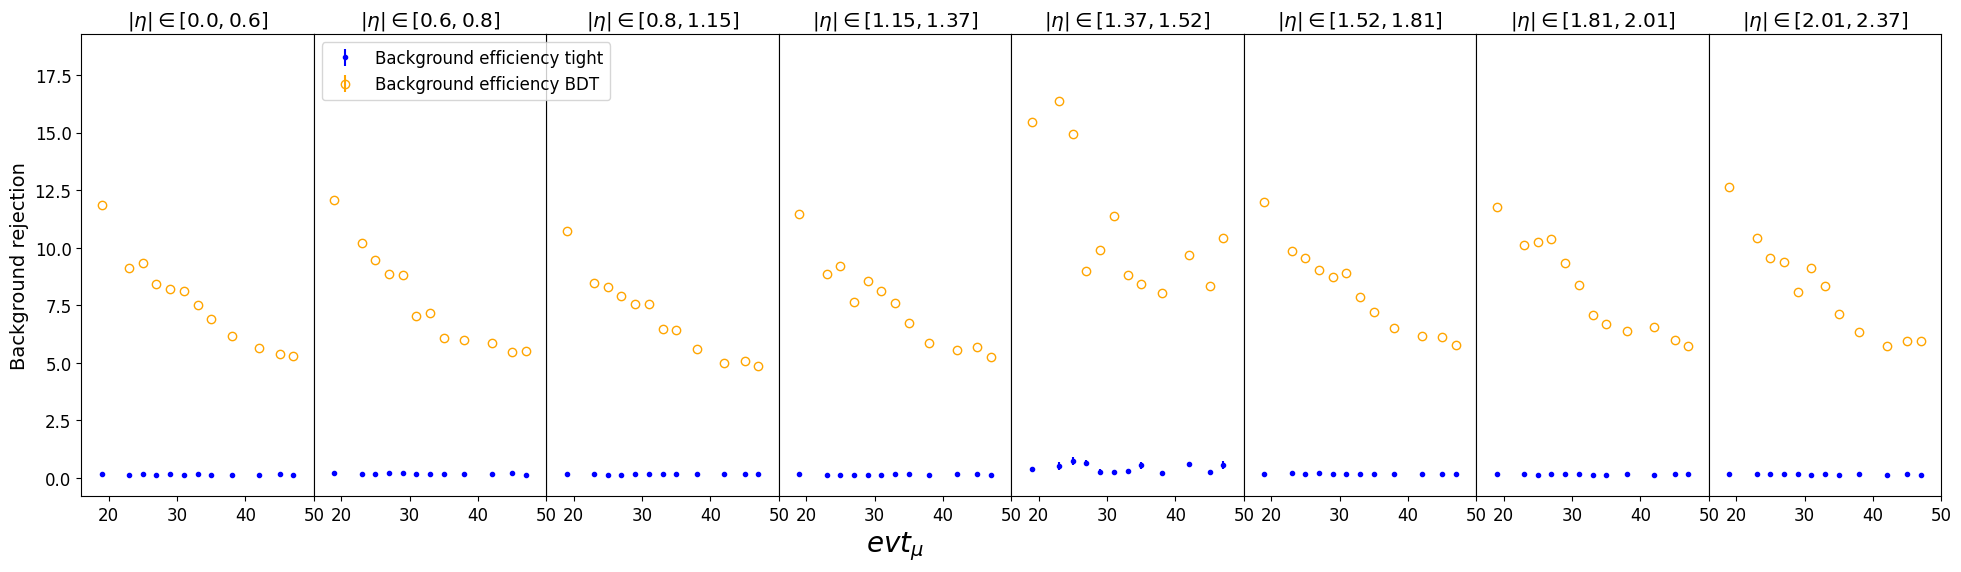

In [39]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_bkg_tight_Cvrt[i] , efferr_bkg_tight_Cvrt[i],
                   fmt=".", label='Background efficiency tight', color = 'blue')
    ax[i].errorbar(mu, eff_bkg_bdt_Cvrt[i] , efferr_bkg_bdt_Cvrt[i],
                   fmt="o", fillstyle='none', label='Background efficiency BDT', color = 'orange')    
    #ax[i].set_xscale('log')
    if (i!=0): ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    ax[i].set_xlim([16, 50])
    
ax[0].set_ylabel("Background rejection",  fontsize=14)
ax[3].set_xlabel("$evt_{\mu}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

#plt.savefig(savedir+"BDT_PID_reject_effi/BDT_PID_rejection_MU_etaBin_Finetunne.pdf")
plt.show()

In [40]:
gridspec_kw={"height_ratios": (3, 1)},

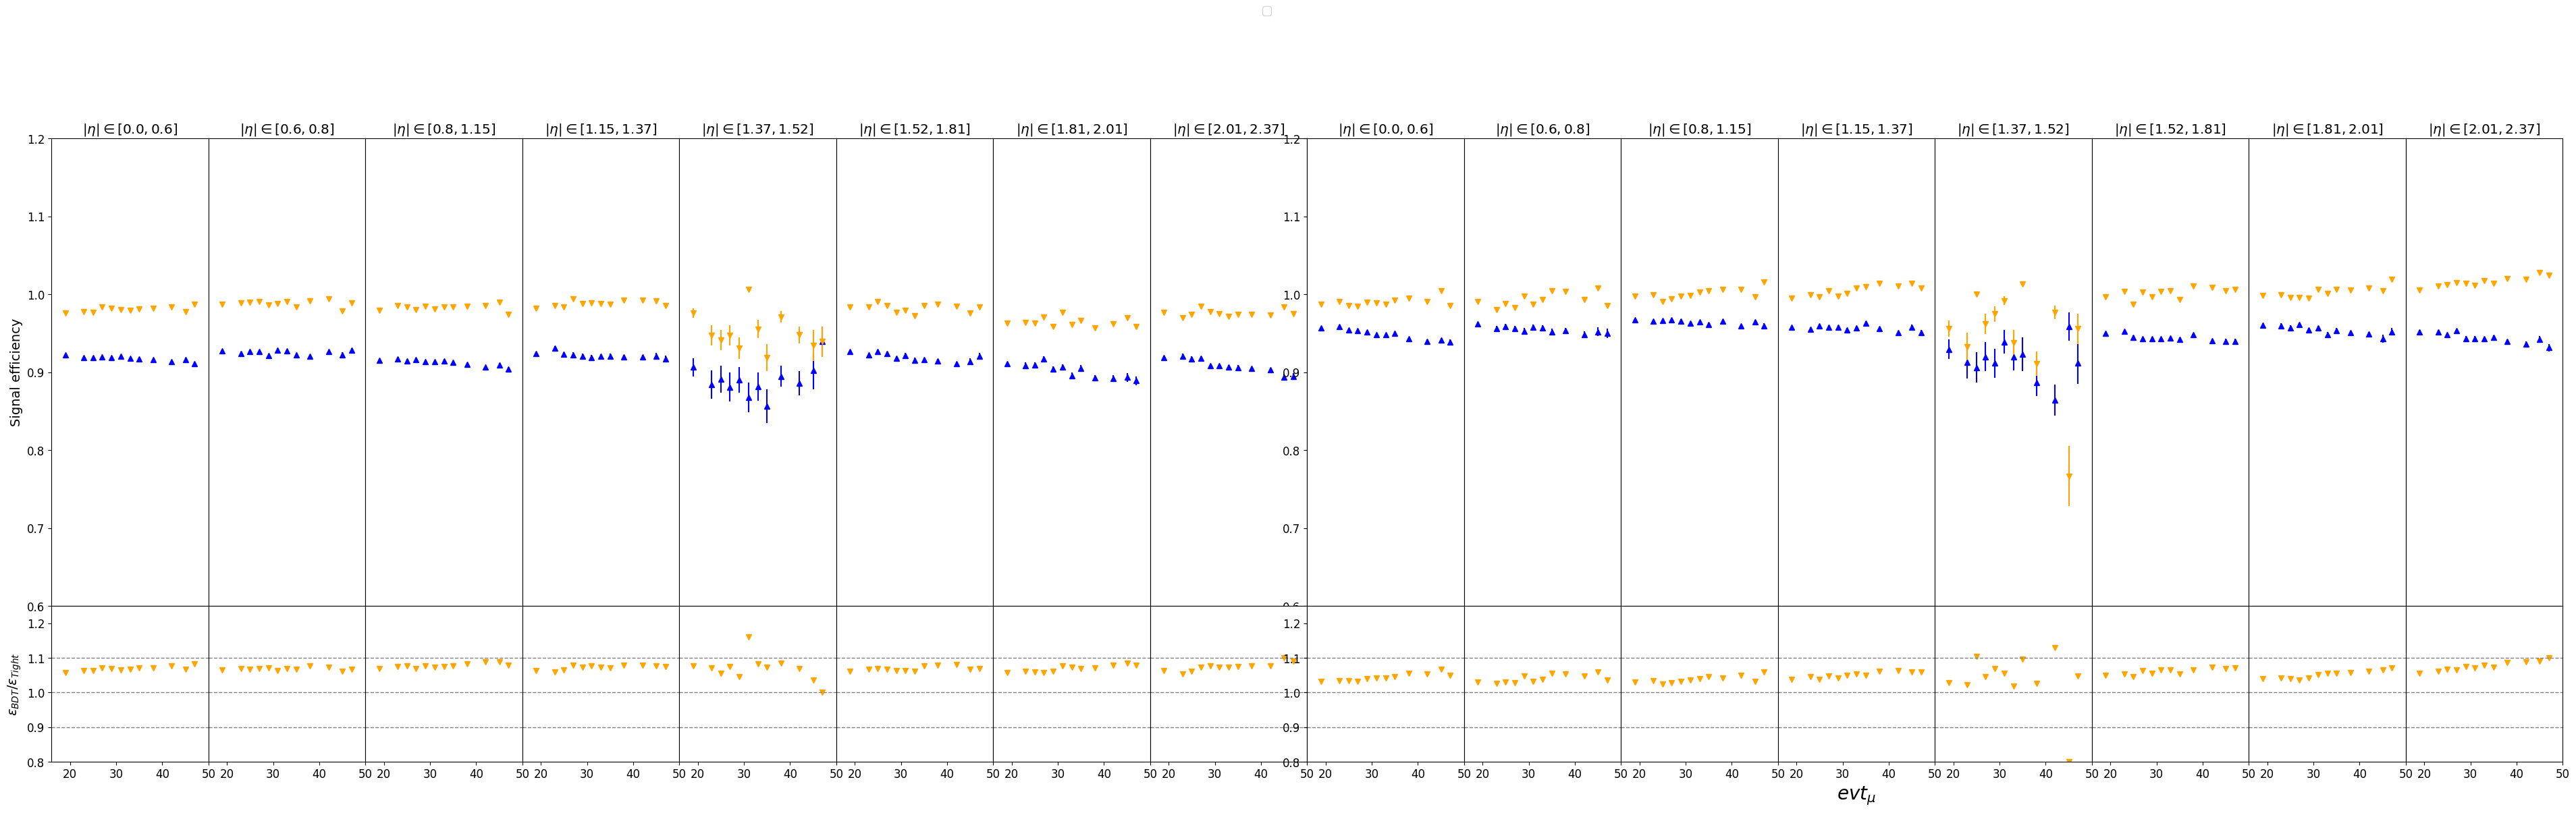

In [41]:
fig, (ax, rax) = plt.subplots(nrows=2, ncols=16, figsize=(48, 12), 
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace=0, hspace=0)

# Initialisation des handles pour les légendes
handles = []

# Boucle pour les photons non convertis (colonne de gauche)
for i in range(8):
    ax[i].errorbar(mu, eff_sig_tight_UnCvrt[i], efferr_sig_tight_UnCvrt[i],
                   fmt="^", label='Signal efficiency tight', color='blue')
    ax[i].errorbar(mu, eff_sig_bdt_UnCvrt[i], efferr_sig_bdt_UnCvrt[i],
                   fmt="v", label='Signal efficiency ID BDT same efficiency', color='orange')
    if i != 0:
        ax[i].set_yticks([])

# Boucle pour les photons convertis (colonne de droite)
for i in range(8, 16):
    ax[i].errorbar(mu, eff_sig_tight_Cvrt[i - 8], efferr_sig_tight_Cvrt[i - 8],
                   fmt="^", label='Signal efficiency tight', color='blue')
    ax[i].errorbar(mu, eff_sig_bdt_Cvrt[i - 8], efferr_sig_bdt_Cvrt[i - 8],
                   fmt="v", label='Signal efficiency ID BDT same efficiency', color='orange')
    if i != 8:
        ax[i].set_yticks([])

# Configuration des titres et des axes pour les photons non convertis
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title=text)
    rax[i].plot(mu, eff_sig_bdt_UnCvrt[i] / eff_sig_tight_UnCvrt[i], 'v', color='orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 50])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.6, 1.2])
    if i != 0:
        rax[i].set_yticks([])

# Configuration des titres et des axes pour les photons convertis
for i in range(8, 16):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i - 8], axis_eta.edges[i - 8 + 1])
    ax[i].set(title=text)
    rax[i].plot(mu, eff_sig_bdt_Cvrt[i - 8] / eff_sig_tight_Cvrt[i - 8], 'v', color='orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 50])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.6, 1.2])
    if i != 8:
        rax[i].set_yticks([])

# Étiquetage des axes
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency", fontsize=14)
rax[11].set_xlabel("$evt_{\mu}$", fontsize=20)

# Ajouter les légendes globales
fig.legend(handles, [h.get_label() for h in handles], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=12)

# Afficher la figure
plt.show()


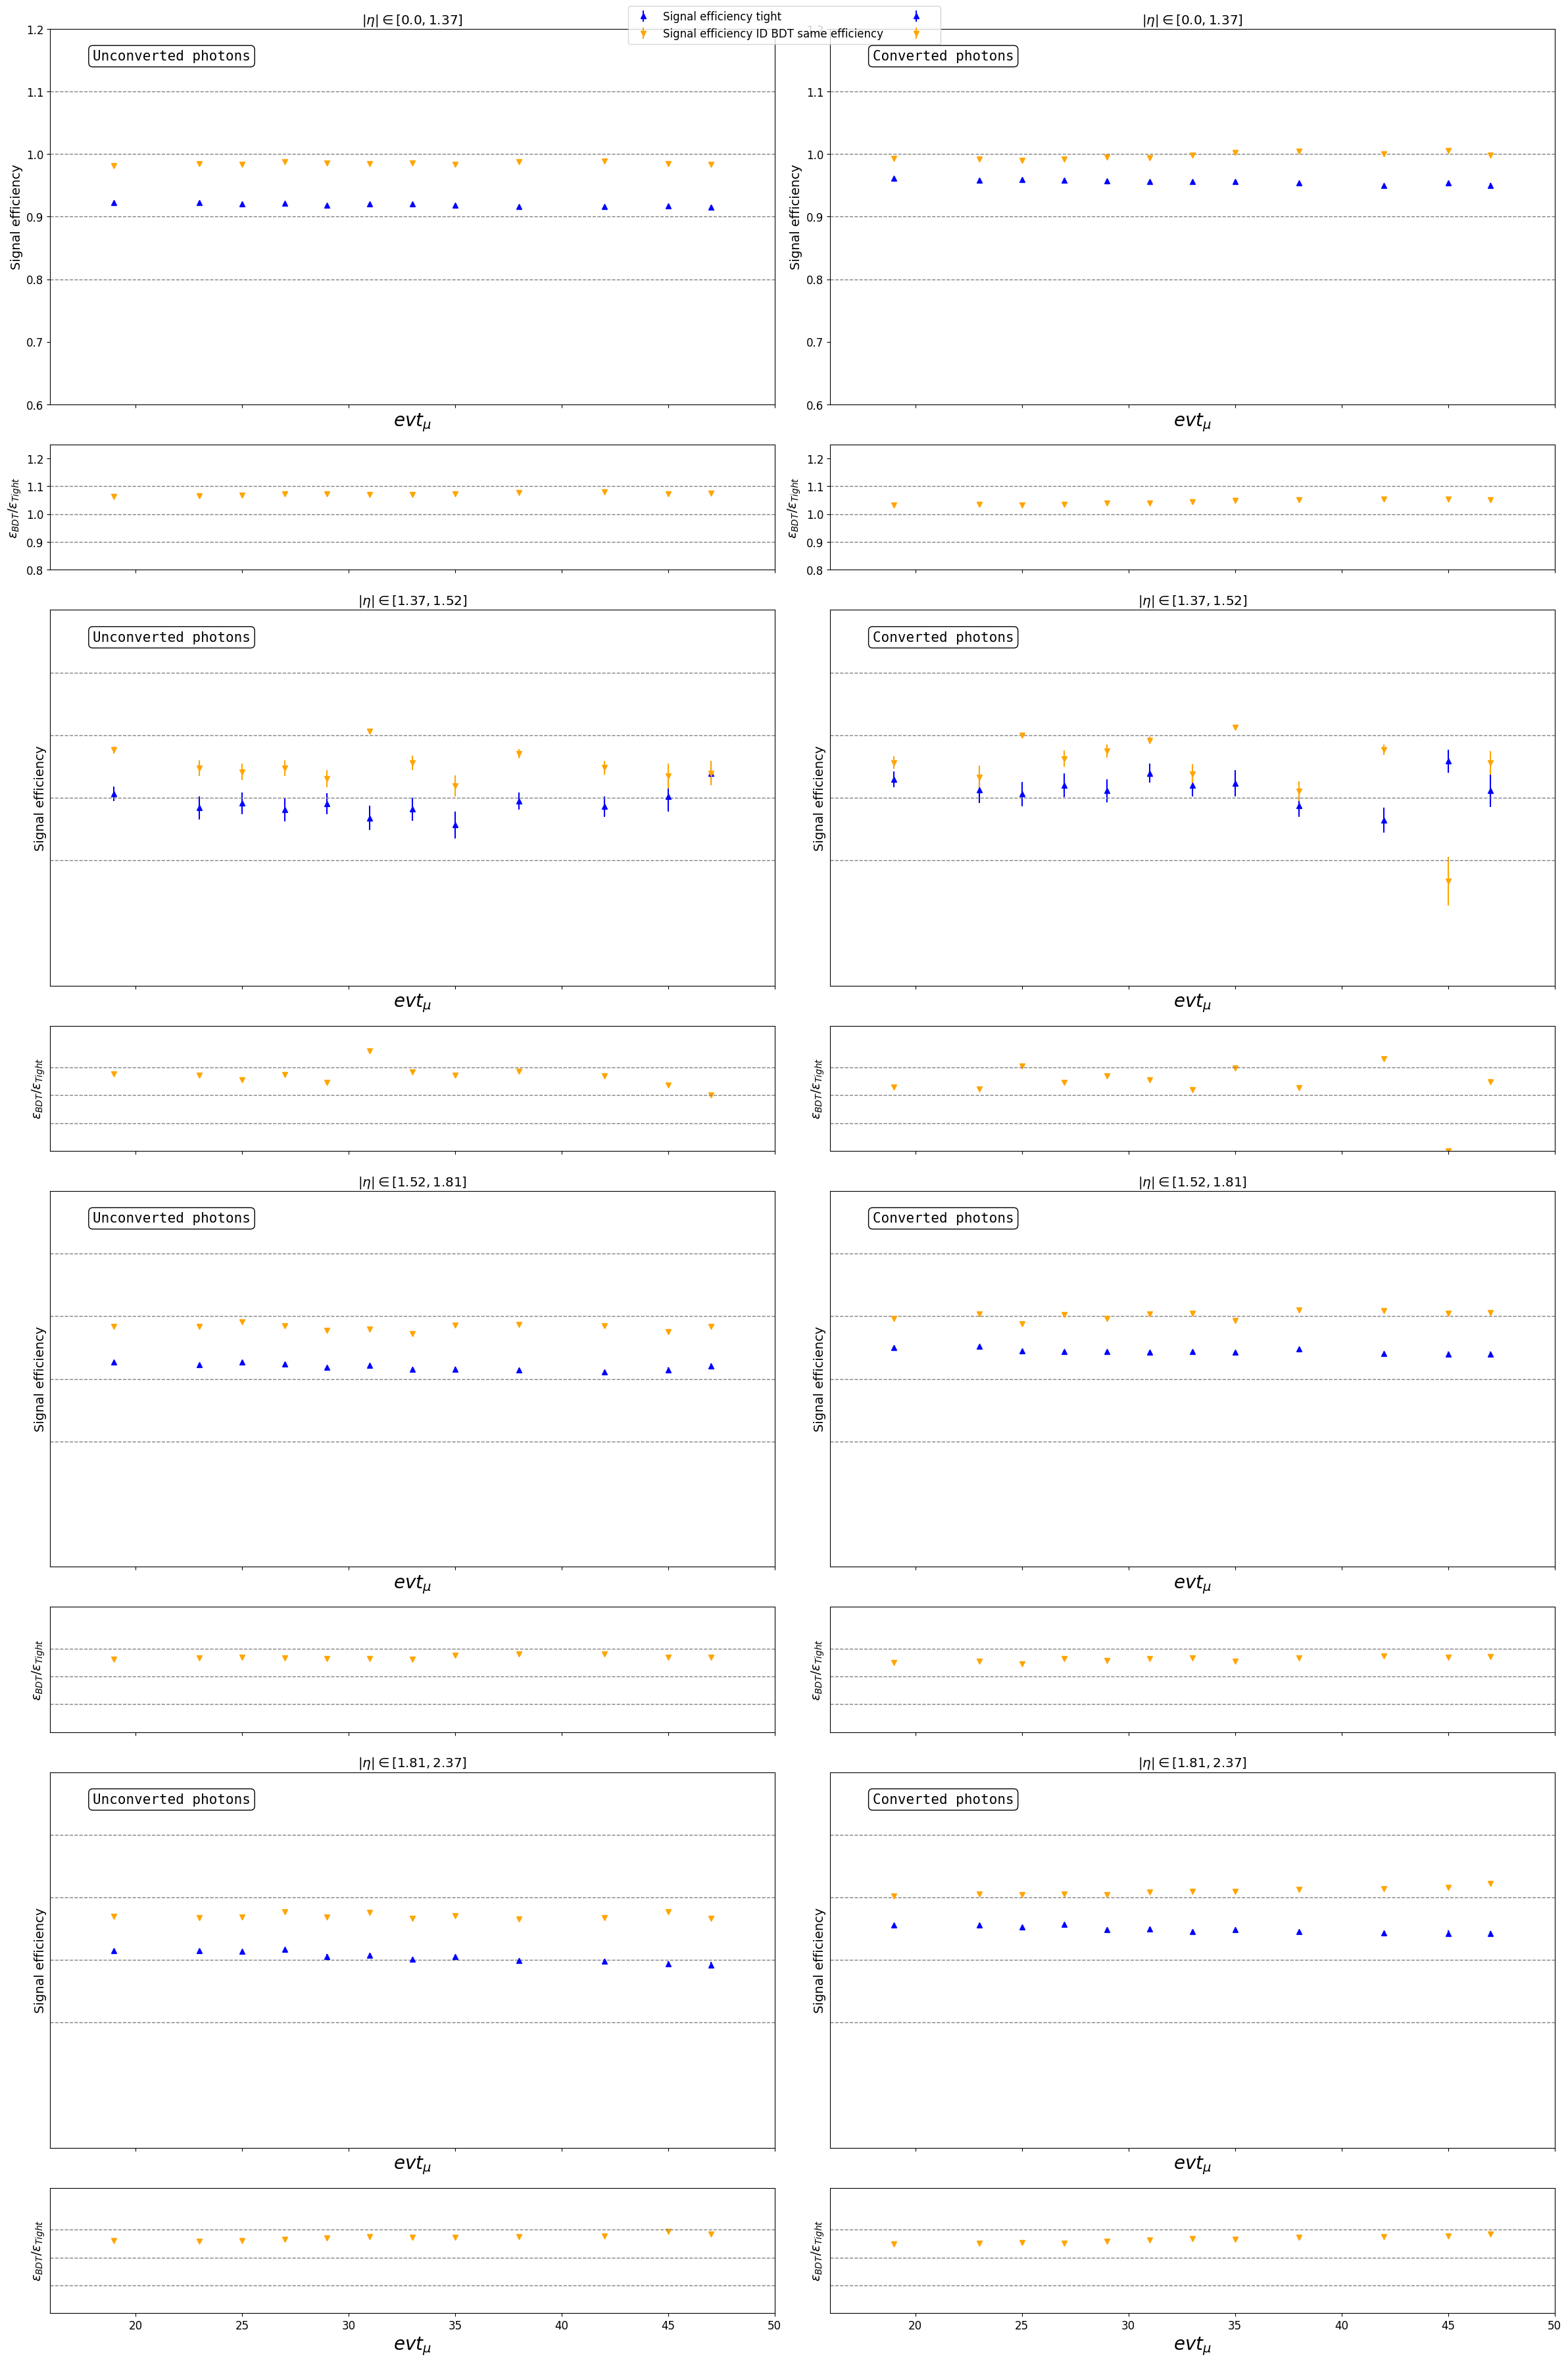

In [65]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

# Déterminer la taille de chaque carré
square_size = 4

# Création de la figure et des sous-graphiques (8 lignes, 2 colonnes)
fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(6 * square_size, 9 * square_size), gridspec_kw={"height_ratios": [3, 1]*4}, 
                        sharex=True)
fig.subplots_adjust(wspace=0.3, hspace=0.1, top=1.2, bottom=0.05, left=0.05, right=0.95)

# Initialisation des handles pour les légendes
handles = []

# Redéfinir les nouveaux bins de eta pour couvrir toute la plage avec seulement 4 bins, incluant [1.37, 1.52]
new_eta_bins = [axis_eta.edges[0], 1.37, 1.52, axis_eta.edges[6], axis_eta.edges[8]]

# Fonction pour déterminer les index des nouveaux bins dans les données
def get_bin_indices(new_bins, old_bins):
    bin_indices = []
    for i in range(len(new_bins) - 1):
        start_index = next(j for j, x in enumerate(old_bins) if x >= new_bins[i])
        end_index = next(j for j, x in enumerate(old_bins) if x >= new_bins[i + 1])
        bin_indices.append((start_index, end_index))
    return bin_indices

# Obtenir les indices des nouveaux bins
bin_indices = get_bin_indices(new_eta_bins, axis_eta.edges)

# Boucle pour les photons non convertis (colonne de gauche)
for i in range(4):
    start_idx, end_idx = bin_indices[i]
    
    ax = axs[2*i, 0]  # Subplot principal pour l'efficacité
    rax = axs[2*i+1, 0]  # Subplot pour le ratio

    # Calculer les moyennes et les erreurs pour les nouveaux bins
    mean_eff_tight_UnCvrt = np.mean(eff_sig_tight_UnCvrt[start_idx:end_idx], axis=0)
    mean_efferr_tight_UnCvrt = np.mean(efferr_sig_tight_UnCvrt[start_idx:end_idx], axis=0)
    mean_eff_bdt_UnCvrt = np.mean(eff_sig_bdt_UnCvrt[start_idx:end_idx], axis=0)
    mean_efferr_bdt_UnCvrt = np.mean(efferr_sig_bdt_UnCvrt[start_idx:end_idx], axis=0)

    # Errorbar pour l'efficacité tight
    errorbar3 = ax.errorbar(mu, mean_eff_tight_UnCvrt, mean_efferr_tight_UnCvrt,
                            fmt="^", label='Signal efficiency tight' if i == 0 else "", color='blue')
    # Errorbar pour l'efficacité BDT
    errorbar4 = ax.errorbar(mu, mean_eff_bdt_UnCvrt, mean_efferr_bdt_UnCvrt,
                            fmt="v", label='Signal efficiency ID BDT same efficiency' if i == 0 else "", color='orange')
    
    ax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.8, color='grey', linestyle='--', linewidth=1)

    # Ajouter les handles pour la légende
    if i == 0:
        handles.append(errorbar3)
        handles.append(errorbar4)

    if i != 0:
        ax.set_yticks([])

    legende = r"$|\eta| \in [{}, {}]$".format(new_eta_bins[i], new_eta_bins[i + 1])
    
    bbox = dict(boxstyle ="round", fc = "white", ec = "black", alpha = 1)
    ax.text(18, 1.15, "Unconverted photons", size=15, bbox=bbox, family="monospace")
    
    ax.set(title=legende)
    ax.set_xlim([16, 50])
    ax.set_ylim([0.6, 1.2])
    ax.set_xlabel("$evt_{\mu}$", fontsize=20)

    rax.plot(mu, mean_eff_bdt_UnCvrt / mean_eff_tight_UnCvrt, 'v', color='orange')
    rax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax.axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax.set_xlim([16, 50])
    rax.set_ylim([0.8, 1.25])
    if i != 0:
        rax.set_yticks([])

# Boucle pour les photons convertis (colonne de droite)
for i in range(4):
    start_idx, end_idx = bin_indices[i]
    
    ax = axs[2*i, 1]  # Subplot principal pour l'efficacité
    rax = axs[2*i+1, 1]  # Subplot pour le ratio

    # Calculer les moyennes et les erreurs pour les nouveaux bins
    mean_eff_tight_Cvrt = np.mean(eff_sig_tight_Cvrt[start_idx:end_idx], axis=0)
    mean_efferr_tight_Cvrt = np.mean(efferr_sig_tight_Cvrt[start_idx:end_idx], axis=0)
    mean_eff_bdt_Cvrt = np.mean(eff_sig_bdt_Cvrt[start_idx:end_idx], axis=0)
    mean_efferr_bdt_Cvrt = np.mean(efferr_sig_bdt_Cvrt[start_idx:end_idx], axis=0)

    # Errorbar pour l'efficacité tight
    errorbar5 = ax.errorbar(mu, mean_eff_tight_Cvrt, mean_efferr_tight_Cvrt,
                            fmt="^", color='blue')
    # Errorbar pour l'efficacité BDT
    errorbar6 = ax.errorbar(mu, mean_eff_bdt_Cvrt, mean_efferr_bdt_Cvrt,
                            fmt="v", color='orange')
    ax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.8, color='grey', linestyle='--', linewidth=1)

    # Ajouter les handles pour la légende
    if i == 0:
        handles.append(errorbar5)
        handles.append(errorbar6)

    if i != 0:
        ax.set_yticks([])
        
    legende = r"$|\eta| \in [{}, {}]$".format(new_eta_bins[i], new_eta_bins[i + 1])
    
    bbox = dict(boxstyle ="round", fc = "white", ec = "black", alpha = 1)
    ax.text(18, 1.15, "Converted photons", size=15, bbox=bbox, family="monospace")

    ax.set(title=legende)
    ax.set_xlim([16, 50])
    ax.set_ylim([0.6, 1.2])
    ax.set_xlabel("$evt_{\mu}$", fontsize=20)

    rax.plot(mu, mean_eff_bdt_Cvrt / mean_eff_tight_Cvrt, 'v', color='orange')
    rax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax.axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax.set_xlim([16, 50])
    rax.set_ylim([0.8, 1.25])
    if i != 0:
        rax.set_yticks([])

# axes pour la colonne de gauche (non convertis)
for i in range(4):
    axs[2*i, 0].set_ylabel("Signal efficiency", fontsize=14)
    axs[2*i+1, 0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
axs[7, 0].set_xlabel("$evt_{\mu}$", fontsize=20)

# axes pour la colonne de droite (convertis)
for i in range(4):
    axs[2*i, 1].set_ylabel("Signal efficiency", fontsize=14)
    axs[2*i+1, 1].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
axs[7, 1].set_xlabel("$evt_{\mu}$", fontsize=20)

# Ajouter les légendes globales
fig.legend(handles, [h.get_label() for h in handles], loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=12)
plt.tight_layout()

plt.savefig(savedir+"BDT_PID_reject_effi/BDT_PID_efficiency_MU_EtaBin_Conv_UnConv.pdf", bbox_inches='tight')

# Afficher la figure
plt.show()


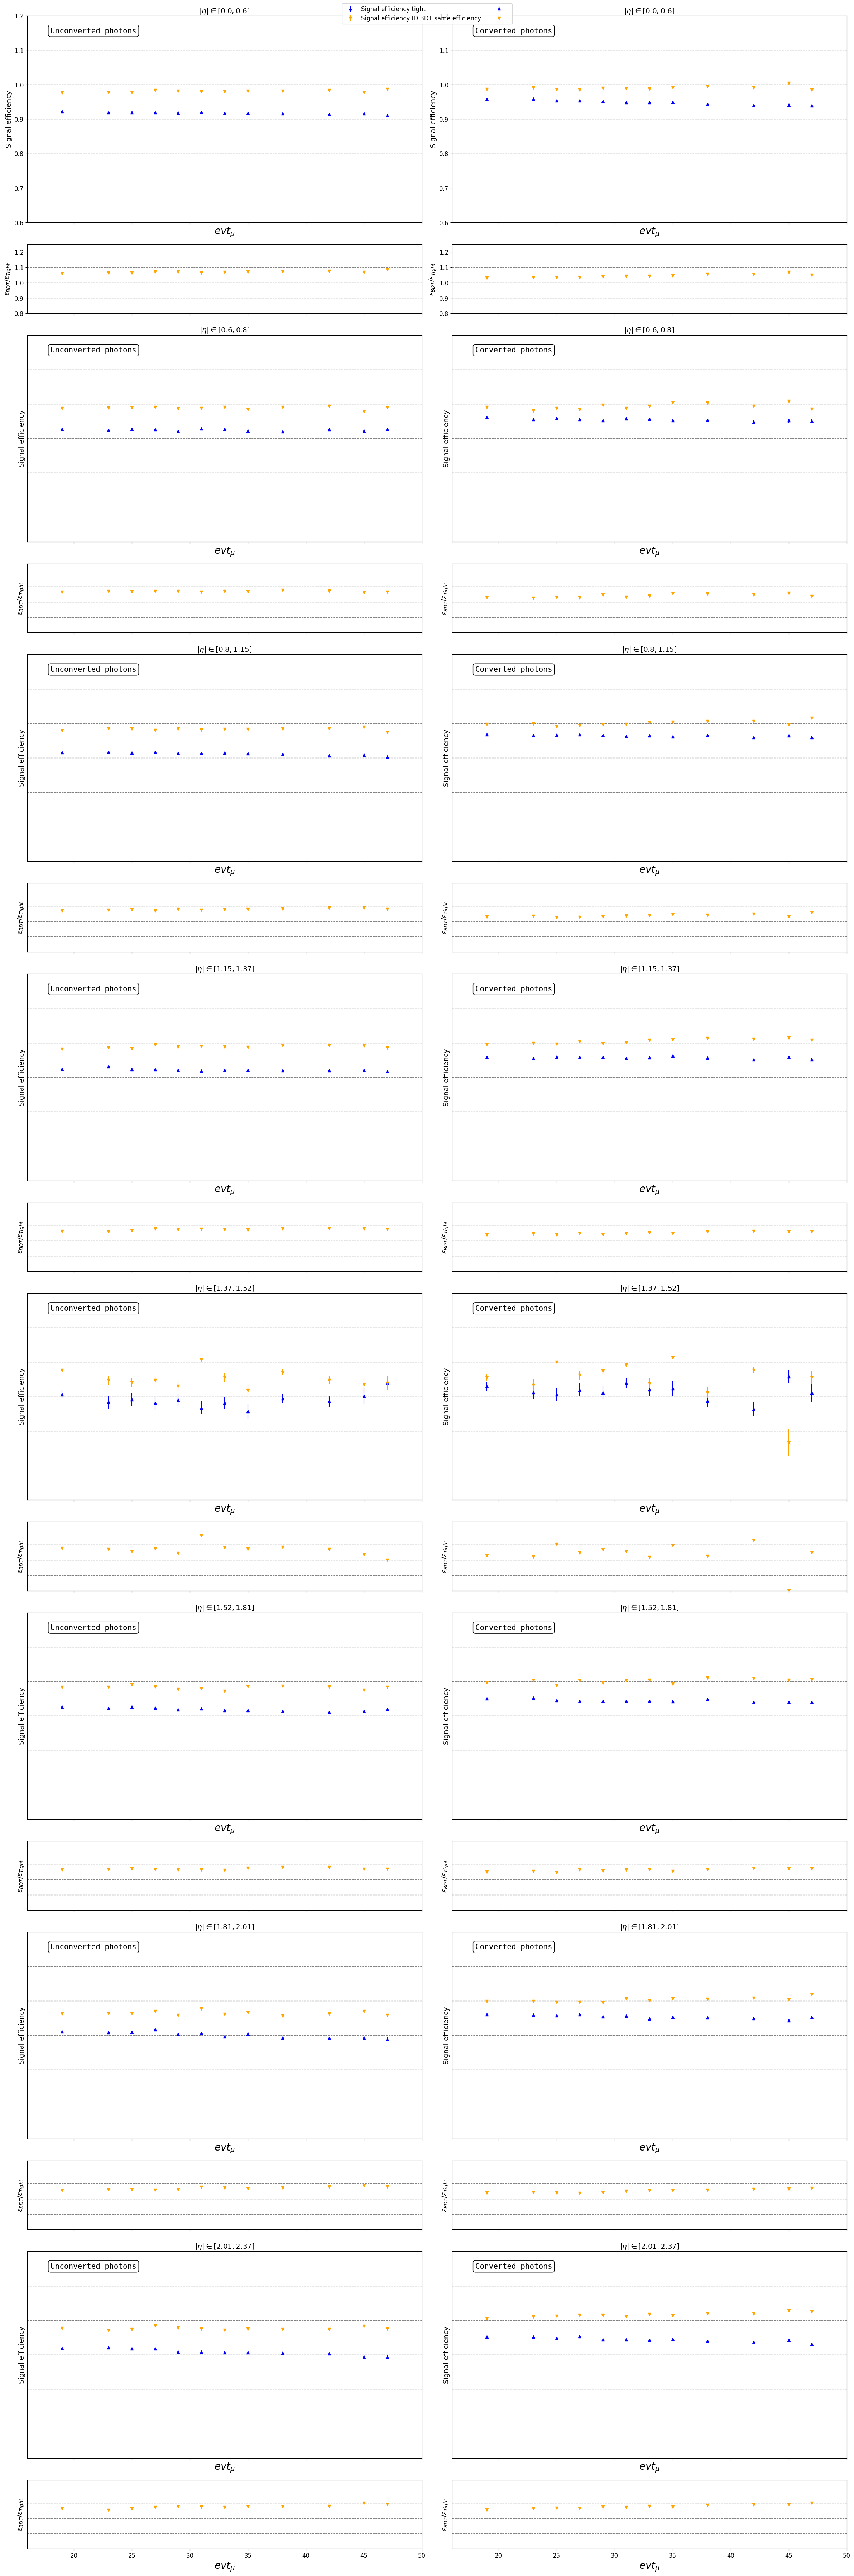

In [61]:
plt.rcParams.update({'font.size': 12})

# Déterminer la taille de chaque carré
square_size = 4

# Création de la figure et des sous-graphiques (16 lignes, 2 colonnes)
fig, axs = plt.subplots(nrows=16, ncols=2, figsize=(6 * square_size, 18 * square_size), gridspec_kw={"height_ratios": [3, 1]*8}, 
                        sharex=True)
fig.subplots_adjust(wspace=0.3, hspace=0.1, top=1.2, bottom=0.05, left=0.05, right=0.95)

# Initialisation des handles pour les légendes
handles = []

# Boucle pour les photons non convertis (colonne de gauche)
for i in range(8):
    ax = axs[2*i, 0]  # Subplot principal pour l'efficacité
    rax = axs[2*i+1, 0]  # Subplot pour le ratio

    # Errorbar pour l'efficacité tight
    errorbar3 = ax.errorbar(mu, eff_sig_tight_UnCvrt[i], efferr_sig_tight_UnCvrt[i],
                            fmt="^", label='Signal efficiency tight' if i == 0 else "", color='blue')
    # Errorbar pour l'efficacité BDT
    errorbar4 = ax.errorbar(mu, eff_sig_bdt_UnCvrt[i], efferr_sig_bdt_UnCvrt[i],
                            fmt="v", label='Signal efficiency ID BDT same efficiency' if i == 0 else "", color='orange')
    
    ax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.8, color='grey', linestyle='--', linewidth=1)

    # Ajouter les handles pour la légende
    if i == 0:
        handles.append(errorbar3)
        handles.append(errorbar4)

    if i != 0:
        ax.set_yticks([])

    legende = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    
    bbox = dict(boxstyle ="round", fc = "white", ec = "black", alpha = 1)
    ax.text(18, 1.15, "Unconverted photons", size=15, bbox=bbox, family="monospace")
    
    ax.set(title=legende)
    ax.set_xlim([16, 50])
    ax.set_ylim([0.6, 1.2])
    ax.set_xlabel("$evt_{\mu}$",  fontsize=20)

    rax.plot(mu, eff_sig_bdt_UnCvrt[i] / eff_sig_tight_UnCvrt[i], 'v', color='orange')
    rax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax.axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax.set_xlim([16, 50])
    rax.set_ylim([0.8, 1.25])
    if i != 0:
        rax.set_yticks([])

# Boucle pour les photons convertis (colonne de droite)
for i in range(8):
    ax = axs[2*i, 1]  # Subplot principal pour l'efficacité
    rax = axs[2*i+1, 1]  # Subplot pour le ratio

    # Errorbar pour l'efficacité tight
    errorbar5 = ax.errorbar(mu, eff_sig_tight_Cvrt[i], efferr_sig_tight_Cvrt[i],
                            fmt="^", color='blue')
    # Errorbar pour l'efficacité BDT
    errorbar6 = ax.errorbar(mu, eff_sig_bdt_Cvrt[i], efferr_sig_bdt_Cvrt[i],
                            fmt="v", color='orange')
    ax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.8, color='grey', linestyle='--', linewidth=1)

    # Ajouter les handles pour la légende
    if i == 0:
        handles.append(errorbar5)
        handles.append(errorbar6)

    if i != 0:
        ax.set_yticks([])
        
    legende = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    
    bbox = dict(boxstyle ="round", fc = "white", ec = "black", alpha = 1)
    ax.text(18, 1.15, "Converted photons", size=15, bbox=bbox, family="monospace")

    ax.set(title=legende)
    ax.set_xlim([16, 50])
    ax.set_ylim([0.6, 1.2])
    ax.set_xlabel("$evt_{\mu}$",  fontsize=20)

    rax.plot(mu, eff_sig_bdt_Cvrt[i] / eff_sig_tight_Cvrt[i], 'v', color='orange')
    rax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax.axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax.set_xlim([16, 50])
    rax.set_ylim([0.8, 1.25])
    if i != 0:
        rax.set_yticks([])

# axes pour la colonne de gauche (non convertis)
for i in range(8):
    axs[2*i, 0].set_ylabel("Signal efficiency", fontsize=14)
    axs[2*i+1, 0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
axs[15, 0].set_xlabel("$evt_{\mu}$", fontsize=20)


# axes pour la colonne de droite (convertis)
for i in range(8):
    axs[2*i, 1].set_ylabel("Signal efficiency", fontsize=14)
    axs[2*i+1, 1].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
axs[15, 1].set_xlabel("$evt_{\mu}$", fontsize=20)



# Ajouter les légendes globales
fig.legend(handles, [h.get_label() for h in handles], loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=12)
plt.tight_layout()

plt.savefig(savedir+"BDT_PID_reject_effi/BDT_PID_efficiency_MU_EtaBin_Conv_UnConv.pdf", bbox_inches='tight')

# Afficher la figure
plt.show()


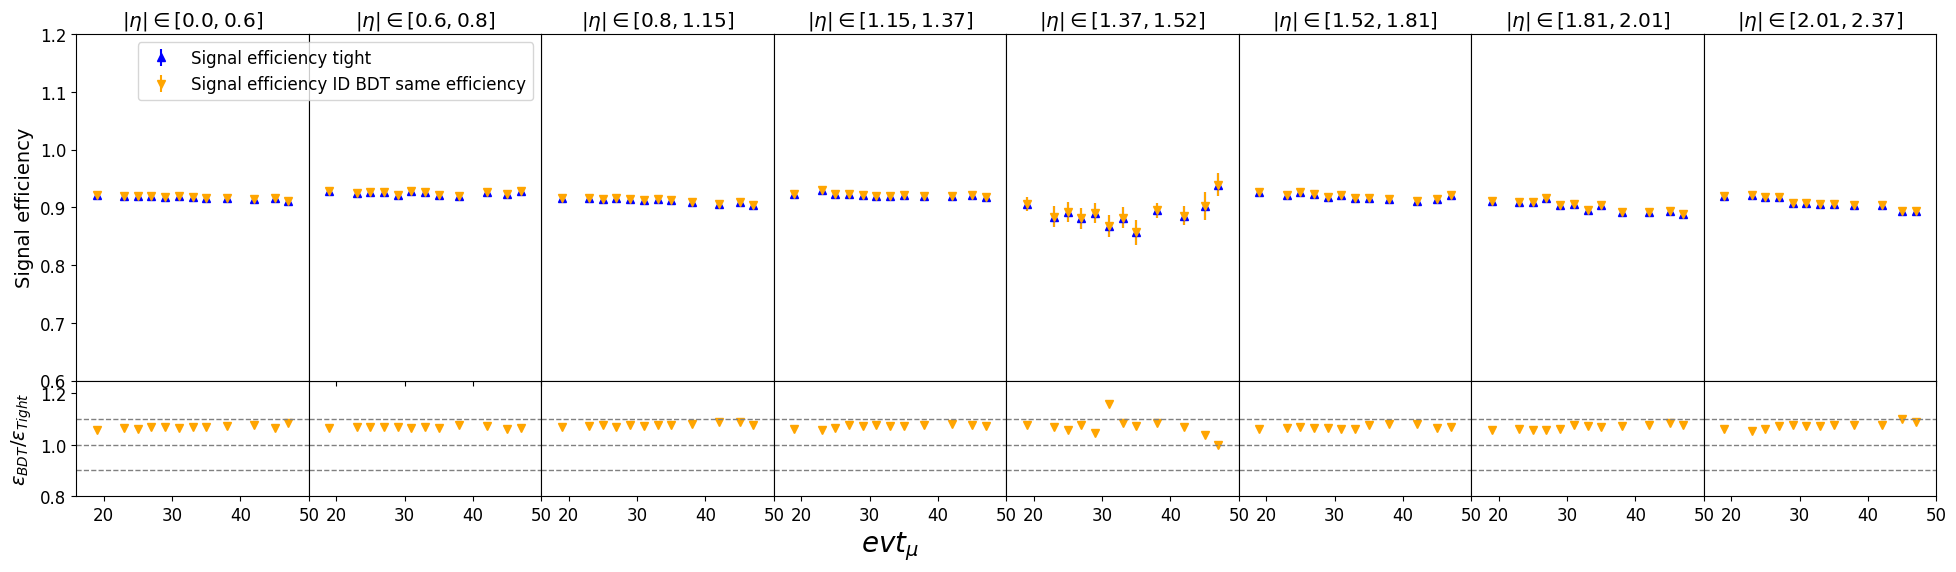

In [44]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(24,6), 
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_sig_tight_UnCvrt[i], efferr_sig_tight_UnCvrt[i],
        fmt="^", label='Signal efficiency tight', color = 'blue')
    ax[i].errorbar(mu, eff_sig_tight_UnCvrt[i], efferr_sig_tight_UnCvrt[i],
        fmt="v", label='Signal efficiency ID BDT same efficiency', color = 'orange')    
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(mu, eff_sig_bdt_UnCvrt[i]/eff_sig_tight_UnCvrt[i], 'v', color = 'orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 50])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.6, 1.2])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$evt_{\mu}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

#plt.savefig(savedir+"BDT_PID_reject_effi/BDT_PID_efficiency_MU_Bin_Finetunne.pdf")
plt.show()

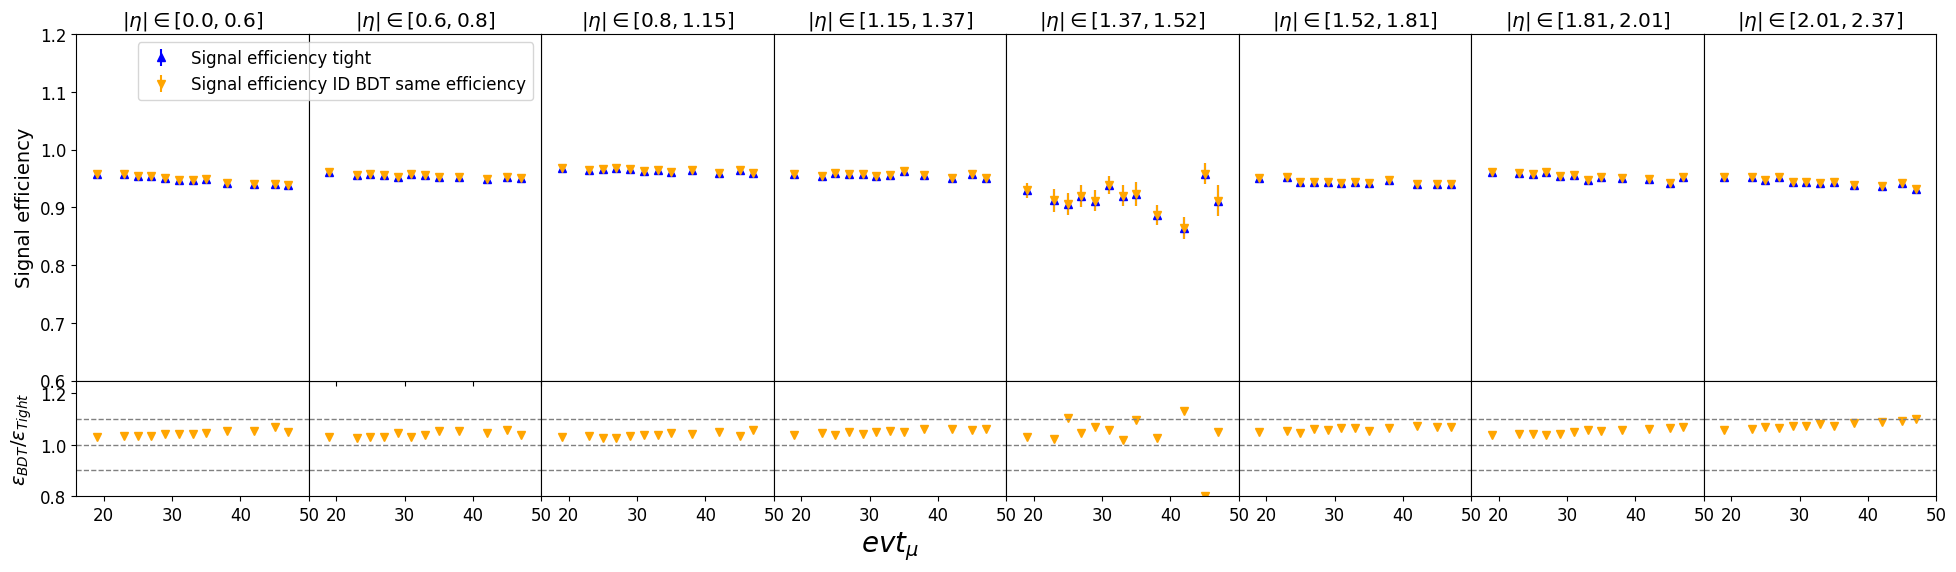

In [45]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(24,6), 
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_sig_tight_Cvrt[i], efferr_sig_tight_Cvrt[i],
        fmt="^", label='Signal efficiency tight', color = 'blue')
    ax[i].errorbar(mu, eff_sig_tight_Cvrt[i], efferr_sig_tight_Cvrt[i],
        fmt="v", label='Signal efficiency ID BDT same efficiency', color = 'orange')    
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(mu, eff_sig_bdt_Cvrt[i]/eff_sig_tight_Cvrt[i], 'v', color = 'orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 50])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.6, 1.2])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$evt_{\mu}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

#plt.savefig(savedir+"BDT_PID_reject_effi/BDT_PID_efficiency_MU_Bin_Finetunne.pdf")
plt.show()

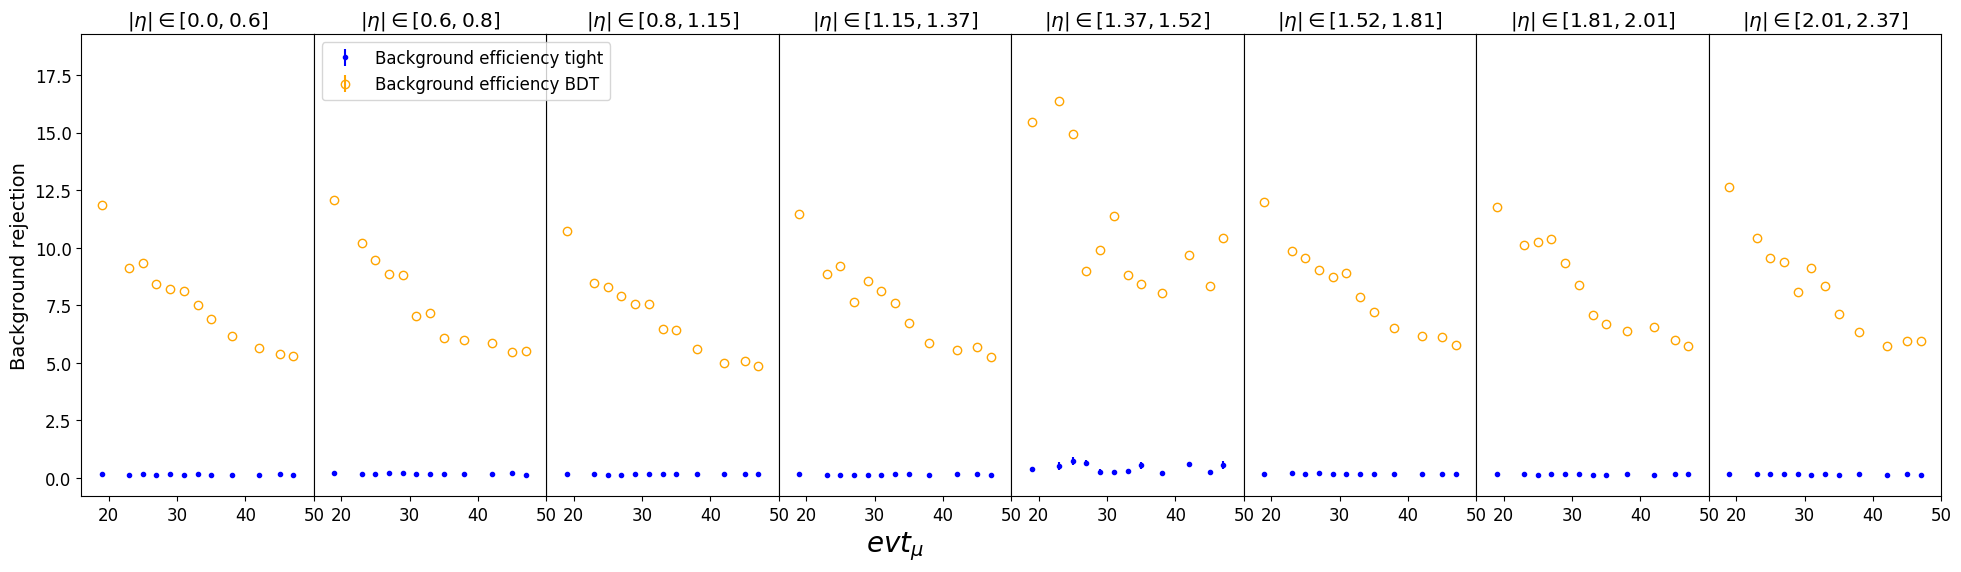

In [46]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_bkg_tight_Cvrt[i] , efferr_bkg_tight_Cvrt[i],
                   fmt=".", label='Background efficiency tight', color = 'blue')
    ax[i].errorbar(mu, eff_bkg_bdt_Cvrt[i] , efferr_bkg_bdt_Cvrt[i],
                   fmt="o", fillstyle='none', label='Background efficiency BDT', color = 'orange')    
    #ax[i].set_xscale('log')
    if (i!=0): ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    ax[i].set_xlim([16, 50])
    
ax[0].set_ylabel("Background rejection",  fontsize=14)
ax[3].set_xlabel("$evt_{\mu}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

#plt.savefig(savedir+"BDT_PID_reject_effi/BDT_PID_rejection_MU_etaBin_Finetunne.pdf")
plt.show()

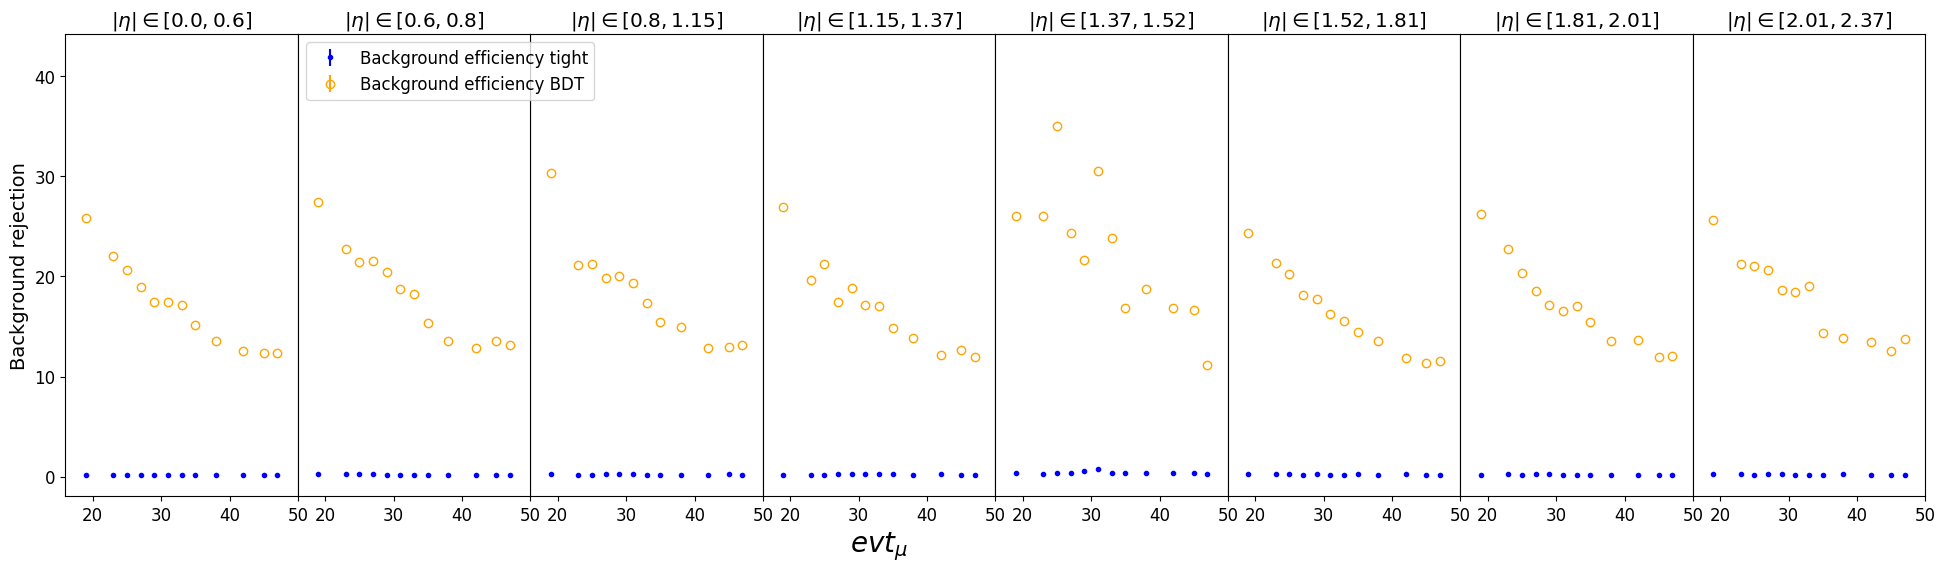

In [47]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_bkg_tight_UnCvrt[i] , efferr_bkg_tight_UnCvrt[i],
                   fmt=".", label='Background efficiency tight', color = 'blue')
    ax[i].errorbar(mu, eff_bkg_bdt_UnCvrt[i] , efferr_bkg_bdt_UnCvrt[i],
                   fmt="o", fillstyle='none', label='Background efficiency BDT', color = 'orange')    
    #ax[i].set_xscale('log')
    if (i!=0): ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    ax[i].set_xlim([16, 50])
    
ax[0].set_ylabel("Background rejection",  fontsize=14)
ax[3].set_xlabel("$evt_{\mu}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

#plt.savefig(savedir+"BDT_PID_reject_effi/BDT_PID_rejection_MU_etaBin_Finetunne.pdf")
plt.show()